# Advanced Fitting with zfit

*Author: X. Cid Vidal*, February 2026

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xabiercidvidal/USC-TA/master)

In [4]:
import time
print( ' Last Execution ', time.asctime())

 Last Execution  Sun Feb  8 11:08:48 2026


In [5]:
# need to install zfit mplhep

# general imports
%matplotlib inline
%reload_ext autoreload
%autoreload 2
#!pip install zfit
#!pip install mplhep
import zfit
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

# Set HEP plotting style (optional but looks nice)
plt.style.use(hep.style.ROOT)

print(f"zfit version: {zfit.__version__}")
print(f"numpy version: {np.__version__}")

/usr/local/lib/python3.12/dist-packages/zfit/__init__.py:93: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


zfit version: 0.28.0
numpy version: 2.0.2


## Introduction & Context

Over the resto of the course, we have covered the theory of probabilities, Probability Density Functions (PDFs), Likelihoods, and Confidence Intervals. Now, we will apply this knowledge using **zfit**, a powerful Python library for model fitting in High Energy Physics (HEP).

### The Goal of Fitting
In high energy physics, we often observe a distribution of data (e.g., invariant mass of particle candidates) and want to extract physical parameters, such as:
* **Mass ($m$):** Where the peak is located.
* **Width ($\Gamma$ or $\sigma$):** How wide the peak is (related to particle lifetime or detector resolution).
* **Yield ($N_{sig}$):** How many signal events we observed.



To do this, we construct a **Model** (a mathematical function) that describes what we expect the data to look like, and we "fit" this model to the data to find the best parameters.

*Note a dataset is not fitted, we fit a model to a dataset!*

### Signal vs. Background
Real data is rarely pure. It usually consists of two components:
1.  **Signal:** The interesting physics process (usually a peak, like a Gaussian or Crystal Ball function).
2.  **Background:** Random noise or other boring physics processes (usually a smooth shape, like an Exponential or Polynomial).

Our model is typically a sum of these components:
$$PDF_{total}(x) = f_{sig} \cdot PDF_{sig}(x) + (1 - f_{sig}) \cdot PDF_{bkg}(x)$$

<img src="https://cds.cern.ch/record/2922458/files/Figure_001-a.png" alt="drawing" width="600"/>



### Maximum Likelihood Estimation (MLE)
How do we find the "best" parameters? We use the **Likelihood** function, $\mathcal{L}$. The likelihood tells us: *Given a set of parameters $\theta$, how probable is it to observe our specific dataset?*

$$\mathcal{L}(\theta) = \prod_{i=1}^{N} PDF(x_i; \theta)$$

As we saw, in practice, we minimize the Negative Log-Likelihood (NLL) because it is numerically more stable and turns the product into a sum:
$$-\ln\mathcal{L}(\theta) = - \sum_{i=1}^{N} \ln PDF(x_i; \theta)$$

Minimizing this value gives us the best-fit parameters $\hat{\theta}$.

## zfit vs. RooFit

In High Energy Physics (HEP), we have specific needs for fitting software:

* **Complex Models:** We often fit sums of products of PDFs (e.g., Signal  Efficiency + Background).
* **Normalization:** PDFs must be normalized over specific ranges, which requires accurate integration.
* **Statistical Treatment:** We need rigorous error estimation (Profile Likelihood, Minos errors).



### RooFit (The Standard)

For over 20 years, **RooFit** (part of the ROOT framework, C++) has been the gold standard.

* **Pros:** Extremely mature, handles almost any statistical problem, deeply integrated with ROOT data formats.
* **Cons:** C++ based (steep learning curve), can be slow with very large datasets, hard to debug, and difficult to integrate with modern Python machine learning tools.

### zfit (The Modern Python Alternative)

**zfit** is a pure Python library built on top of **TensorFlow**.

* **Pros:**
    * **Pythonic:** easy to extend and debug.
    * **Scalable:** Uses TensorFlow's computational graph, allowing it to run on GPUs and handle millions of events efficiently.
    * **Ecosystem:** Integrates seamlessly with the "Scikit-HEP" stack (`uproot`, `awkward`, `mplhep`).


* **Cons:** Newer, so it has fewer legacy features than RooFit.





## The Engine Under the Hood: Minuit

You will often hear the phrase "Minimizing the Negative Log-Likelihood." But *how* do we actually find the minimum?

We use **Minuit**, a numerical minimization library originally written at CERN in the 1970s by Fred James. It is arguably the most successful piece of software in the history of particle physics.



### What does Minuit do?

Minuit is a "gradient descent" optimizer, but on steroids. It doesn't just look at the slope (gradient) of the function; it looks at the curvature (second derivative/Hessian).

1. **MIGRAD:** The main algorithm. It uses the **Davidon-Fletcher-Powell (DFP)** formula to jump towards the minimum efficiently. It assumes the function looks roughly like a parabola (quadratic) near the minimum.
2. **HESSE:** Once at the minimum, it calculates the **Hessian matrix** (the matrix of second derivatives). The inverse of this matrix gives us the **Covariance Matrix**, which contains the parameter errors and correlations.
3. **MINOS:** If the likelihood is not parabolic (non-linear correlations), HESSE errors are not enough. MINOS explicitly scans the likelihood function to find the asymmetric  intervals.

In `zfit`, we use `iminuit`, which is a fast Python wrapper around the C++ Minuit2 engine.

## zfit building blocks

In zfit, everything is an object. We need to define the "Universe" our physics lives in before we can do anything.

### The Observable Space (`zfit.Space`)
The domain of definition for our PDF. If we fit a mass peak, this is the mass range.

$$ \text{Observable} \in [\text{min}, \text{max}] $$

In [6]:
# Define the B meson mass range
obs = zfit.Space("mass", limits=(5000, 6000)) # MeV

### Parameters (`zfit.Parameter`)
Variables that the fitter can change (float) or that we keep constant (fix).

Syntax: `zfit.Parameter(name, value, [lower, upper], [step_size])`

* If limits are provided, the parameter is **floating** (fits can change it).
* If limits are `None` (or not provided), the parameter is **fixed**.

In [7]:
# Signal parameters (Gaussian)
mu = zfit.Parameter("mu", 5279, 5200, 5350)     # Floating
sigma = zfit.Parameter("sigma", 30, 1, 100)     # Floating

# Background parameters (Exponential)
lam = zfit.Parameter("lambda", -0.002, -0.01, 0) # Floating

### Probability Density Functions (PDFs)
zfit provides standard shapes in `zfit.pdf` (Gauss, CrystalBall, Exponential, Voigt, etc.).

We will build a simple **Signal + Background** model.

$$ PDF_{total}(x) = f_{sig} \cdot G(x; \mu, \sigma) + (1 - f_{sig}) \cdot E(x; \lambda) $$

In [8]:
# Create component PDFs
signal_pdf = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs, name="Signal")
bkg_pdf = zfit.pdf.Exponential(lambda_=lam, obs=obs, name="Background")

# Create the combined model
frac = zfit.Parameter("frac", 0.3, 0, 1) # 30% signal fraction guess
model = zfit.pdf.SumPDF([signal_pdf, bkg_pdf], fracs=frac)

**Example:** generating and plotting data

For this example, we will generate "Toy MC" data from the model itself. In a real analysis, you would load this from a ROOT file or Pandas DataFrame.

Note: We can fix the parameters temporarily to generate "True" data, then randomize them before fitting.

Generated 5000 events.


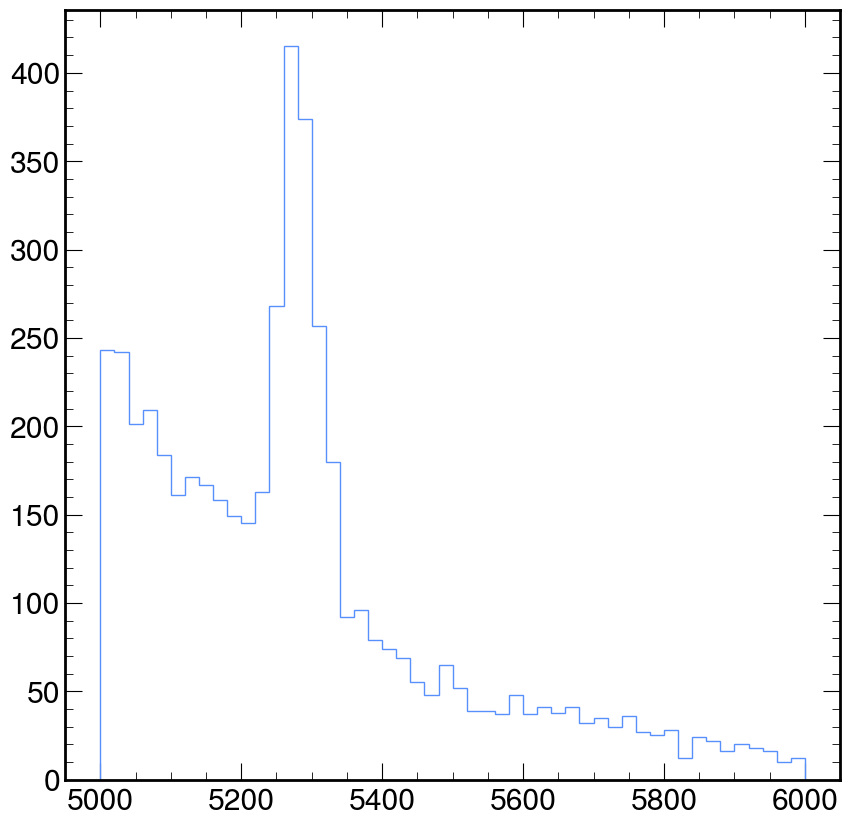

In [9]:
# Set "True" values for generation
mu.set_value(5280) ## B meson mass
sigma.set_value(25) ## usual LHCb resolution
lam.set_value(-0.003)
frac.set_value(0.2) ## sample has 20% signal fraction

# Sample 5000 events
n_events = 5000
data = model.sample(n=n_events)

# Convert to numpy for basic plotting
data_np = data.numpy()
print(f"Generated {len(data_np)} events.")

# Simple check
plt.hist(data_np, bins=50, histtype='step');

## The Fit (Unbinned Likelihood)

In this case we use the **Unbinned Negative Log-Likelihood (NLL)**: Minimizing it yields the best estimators for parameters $\theta$.

*Note: an alternative could be a binned fit, typically less convenient as it relies on the binning choice.*

In [10]:
# 1. Randomize parameters so the fit has work to do
mu.set_value(5250)
sigma.set_value(50)
lam.set_value(-0.001)
frac.set_value(0.5)

# 2. Define the Loss Function
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

# 3. Define the Minimizer (Minuit)
minimizer = zfit.minimize.Minuit()

# 4. Run the minimization
result = minimizer.minimize(nll)

### Analyzing the Result
The `result` object contains the parameter values, validity checks, and can compute errors.

In [11]:
print(f"Fit Converged: {result.converged}")
print(f"Fit Valid: {result.valid}")

# Compute Hessian Errors (Parabolic approximation)
result.hesse()

print(result.params)

Fit Converged: True
Fit Valid: True
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
frac              0.203144  +/-  0.0085       False
mu                 5281.44  +/-     1.3       False
sigma              26.2567  +/-     1.2       False
lambda         -0.00295331  +/- 6.7e-05       False


### Visualization
A fit is worthless if you don't check it visually. In HEP, we almost always plot:
1.  **Data** (Error bars)
2.  **Model** (Line)
3.  **Pulls** (Residuals normalized by error): $\frac{N_{data} - N_{model}}{\sigma}$

/tmp/ipython-input-3302394765.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lower, upper = float(lower_arr[0]), float(upper_arr[0])


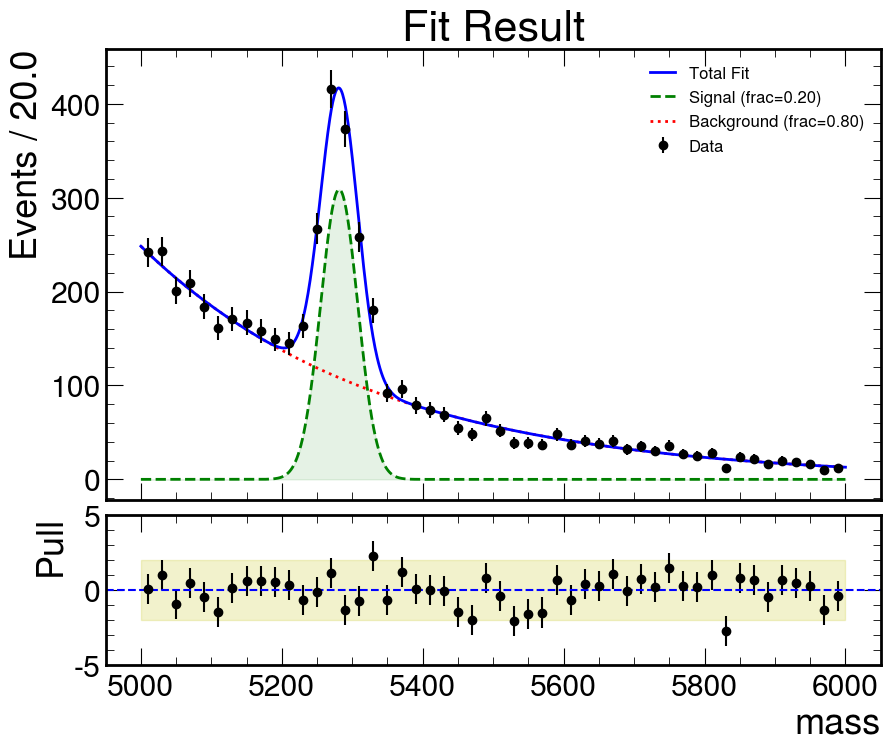

In [12]:
def plot_fit_with_components(model, data, obs, bins=50, title="Fit Result"):
    # 1. Prepare Data
    obs_name = obs.obs[0]
    data_np = data.value(obs_name).numpy().flatten()
    n_data = len(data_np) # Total events

    # 2. Prepare Limits
    lower_arr, upper_arr = obs.rect_limits
    lower, upper = float(lower_arr[0]), float(upper_arr[0])

    # 3. Histogram Data
    counts, edges = np.histogram(data_np, bins=bins, range=(lower, upper))
    centers = (edges[:-1] + edges[1:]) / 2
    yerr = np.sqrt(counts)

    # 4. Plot Setup
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    # --- Plot Data ---
    ax1.errorbar(centers, counts, yerr=yerr, fmt='ko', label="Data", zorder=10)

    # --- Plot Total Model ---
    x_plot = np.linspace(lower, upper, 1000)
    bin_width = (upper - lower) / bins

    # Scale PDF to data count (N_data * Bin_width)
    scale_factor = n_data * bin_width

    # Evaluate Total PDF
    # Reshape x_plot to (N, 1) for zfit
    y_total = model.pdf(x_plot.reshape(-1, 1)).numpy() * scale_factor
    ax1.plot(x_plot, y_total, 'b-', label="Total Fit", linewidth=2, zorder=5)

    # --- Plot Components (Using Fractions) ---
    if isinstance(model, zfit.pdf.SumPDF):
        styles = ['g--', 'r:', 'm-.']
        pdfs = model.pdfs
        fracs = [f.numpy() for f in model.fracs] # Extract fraction values

        # The last fraction is implicit (1 - sum(others))
        if len(fracs) < len(pdfs):
            fracs.append(1.0 - sum(fracs))

        for i, (pdf, frac) in enumerate(zip(pdfs, fracs)):
            # Evaluate component PDF (normalized to 1)
            y_comp_norm = pdf.pdf(x_plot.reshape(-1, 1)).numpy()

            # Scale by Fraction * Total Events * Bin Width
            y_comp = y_comp_norm * frac * scale_factor

            # Plot
            label = pdf.name if pdf.name else f"Comp {i}"
            ax1.plot(x_plot, y_comp, styles[i % len(styles)], linewidth=2, label=f"{label} (frac={frac:.2f})")

            # Optional: Shade the Signal
            if i == 0:
                 ax1.fill_between(x_plot, y_comp, color='g', alpha=0.1)

    ax1.set_ylabel(f"Events / {bin_width:.1f}")
    ax1.set_title(title)
    ax1.legend(fontsize=12)

    # --- Plot Pulls ---
    y_model_at_centers = model.pdf(centers.reshape(-1, 1)).numpy() * scale_factor

    safe_yerr = yerr.copy()
    safe_yerr[safe_yerr == 0] = 1
    pulls = (counts - y_model_at_centers) / safe_yerr

    ax2.errorbar(centers, pulls, yerr=1, fmt='ko')
    ax2.axhline(0, color='b', linestyle='--')
    ax2.fill_between([lower, upper], -2, 2, color='y', alpha=0.2, label=r"$2\sigma$")
    ax2.set_ylabel("Pull")
    ax2.set_xlabel(f"{obs_name}")
    ax2.set_ylim(-5, 5)

    plt.subplots_adjust(hspace=0.05)
    plt.show()

# Run it
plot_fit_with_components(model, data, obs)

**Class exercise:** Improve the Model
- Replace the `zfit.pdf.Gauss` signal with a `zfit.pdf.CrystalBall`.
    * You will need two new parameters: `alpha` (try ~1.0) and `n` (try ~2.0).
-  Generate the dataset and perform the fit again.
-  Compare the standard deviation (`sigma`) obtained from the Gaussian fit (on the new dataset) vs the CB fit.

## Extended Likelihoods (Fitting Yields)

So far, we fitted the **fraction** (`frac`) of signal. The total number of events was fixed to the observed number.

In physics, we want to know the **Yield** ($N_{sig}$, $N_{bkg}$) and its uncertainty.
We use the **Extended Likelihood**, which adds a Poisson term to the NLL:

$$ -\ln \mathcal{L}_{ext} = -\sum \ln P(x_i) + (N_{exp} - N_{obs} \ln N_{exp}) $$

In zfit, we just attach a yield parameter to the PDF.

In [13]:
# 1. Define Yield Parameters (Floating)
n_sig = zfit.Parameter("n_sig", 1000, 0, 10000)
n_bkg = zfit.Parameter("n_bkg", 4000, 0, 10000)

# 2. Extend the PDFs
# Note: We don't need 'frac' anymore. The sum is determined by n_sig + n_bkg
signal_ext = signal_pdf.create_extended(n_sig)
bkg_ext = bkg_pdf.create_extended(n_bkg)

# 3. Create Sum
model_ext = zfit.pdf.SumPDF([signal_ext, bkg_ext])

# 4. Loss (Note: ExtendedUnbinnedNLL)
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model_ext, data=data)

# 5. Fit
result_ext = minimizer.minimize(nll_ext)
result_ext.hesse()
print(result_ext.params)

name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
n_sig              1015.75  +/-      45       False
n_bkg              3984.25  +/-      71       False
mu                 5281.44  +/-     1.3       False
sigma              26.2569  +/-     1.2       False
lambda         -0.00295334  +/- 6.7e-05       False


**Exercise**: Uncertainty Scaling
In a simple counting experiment, the error on $N$ is $\sqrt{N}$.
1.  Check the error on `n_sig` from the fit output.
2.  Is it larger or smaller than $\sqrt{N_{sig}}$?
3.  **Thought experiment:** Why is it different? (Hint: Does the background shape look like the signal?)

## Constraints (Systematics)

Remember the concept of "nuisance parameters" in the hypothesis_test notebook! Let's see how to implement the [the Cousins-Highland method](http://www.sciencedirect.com/science/article/pii/0168900292907945) also known as a bayesian-frequentist hybrid method.

Often, we know something about a parameter from an external source (e.g., the uncertainty on the integrated luminosity is known to be 1%). We can add this information as a **Constraint**.



Mathematically, this multiplies the Likelihood by a Gaussian:
$$ \mathcal{L}_{total} = \mathcal{L}_{data} \times G(\theta; \mu_{ext}, \sigma_{ext}) $$

Let's assume we have a theoretical prediction for the background slope `lambda` = -0.003 +/- 0.0001.

In [16]:
# 1. Define the Constraint
# We constraint the parameter 'lam' to -0.003 with width 0.0001
constraint = zfit.constraint.GaussianConstraint(params=lam, observation=-0.003, uncertainty=0.0001)

# 2. Add to Loss
# Constraints are just added to the likelihood
nll_constrained = zfit.loss.ExtendedUnbinnedNLL(model=model_ext, data=data, constraints=constraint)

# 3. Fit
result_c = minimizer.minimize(nll_constrained)
result_c.hesse()

print(f"Fitted lambda without constraint: {result_ext.params[lam]['value']:.5f} +/- {result_ext.params[lam]['hesse']['error']:.5f}")
print(f"Fitted lambda WITH constraint:    {result_c.params[lam]['value']:.5f} +/- {result_c.params[lam]['hesse']['error']:.5f}")
print(f"Note how the error on `lambda` decreases, and this might propagate to improve the error on `n_sig`!")

Fitted lambda without constraint: -0.00295 +/- 0.00007
Fitted lambda WITH constraint:    -0.00297 +/- 0.00006
Note how the error on `lambda` decreases, and this might propagate to improve the error on `n_sig`!


## Simultaneous Fits

One of the most powerful techniques in HEP is to perform a simultaneous fit to Signal + *Control* Regions.
Imagine we have:
1.  **Signal Region (SR):** Has Signal and Background.
2.  **Control Region (CR):** Has **only** Background (e.g., sideband, or failing a cut).

If the background shape is the same in both (e.g. same exponential slope $\lambda$), we can fit them **simultaneously** to constrain the background much better.

In [17]:
# --- 1. Setup Data ---
# SR Data is 'data' (already generated)

# CR Data: Create a new dataset that is PURE background, but shares the same physics (same lambda)
# Let's assume CR has 2000 events
obs_cr = zfit.Space("mass_cr", limits=(5000, 6000))
bkg_cr_gen = zfit.pdf.Exponential(lambda_=-0.003, obs=obs_cr) # Use true lambda
data_cr = bkg_cr_gen.sample(2000)

# --- 2. Setup Models ---

# Shared Parameter (Slope)
lambda_shared = zfit.Parameter("lambda_shared", -0.002, -0.01, 0)

# SR Model (Sig + Bkg)
sig_sr = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
bkg_sr = zfit.pdf.Exponential(lambda_=lambda_shared, obs=obs) # Uses shared
model_sr = zfit.pdf.SumPDF([sig_sr, bkg_sr], fracs=frac)

# CR Model (Bkg only)
model_cr = zfit.pdf.Exponential(lambda_=lambda_shared, obs=obs_cr) # Uses shared

# --- 3. Combined Loss ---
nll_sr = zfit.loss.UnbinnedNLL(model_sr, data)
nll_cr = zfit.loss.UnbinnedNLL(model_cr, data_cr)

simultaneous_nll = nll_sr + nll_cr

# --- 4. Fit ---
result_sim = minimizer.minimize(simultaneous_nll)
print(result_sim.params)

name             value  (rounded)    at limit
-------------  ------------------  ----------
frac                     0.203119       False
mu                        5281.47       False
sigma                     26.2582       False
lambda_shared         -0.00297977       False


**Exercise:** Shared Resolution:
Imagine you have a $J/\psi \to \mu\mu$ calibration channel.
1.  Generate a calibration dataset (Pure Gaussian, mean=3100, sigma=25).
2.  Set up a simultaneous fit with your Signal Region.
3.  Share the `sigma` parameter between the Signal Region and the Calibration Channel.
4.  See how this constrains the width of your signal peak.

### Combining Distinct Channels

In the previous example, we used a control region to constrain a background shape. Now, let's look at a different use case: **Combining Measurements.**

Imagine we want to measure the **Higgs Signal Strength ($\mu$)**. The Higgs boson decays into many different particles. We can measure it in:
1.  **$H \to b\bar{b}$:** Very common, but messy (poor mass resolution, huge background).
2.  **$H \to \tau\tau$:** Rarer, but cleaner (better resolution).





Both channels are observing the *same* Higgs boson produced with the *same* cross-section. Therefore, we can fit both datasets simultaneously with a **shared parameter** for the signal yield scaling.

#### The Model
* **Shared Parameter:** `mu_signal` (Signal Strength).
* **Channel 1 ($bb$):** Broad Gaussian Signal + Exponential Background.
* **Channel 2 ($\tau\tau$):** Narrow Gaussian Signal + Linear Background.

$$N_{sig, bb} = \mu \cdot N_{SM, bb}$$
$$N_{sig, \tau\tau} = \mu \cdot N_{SM, \tau\tau}$$

In [18]:
# ==========================================
# SIMULTANEOUS FIT: Higgs Combination
# ==========================================

# 1. Setup the Space
obs_mass = zfit.Space("mass", limits=(100, 150))

# --- Shared Parameter of Interest ---
# mu = 1.0 means Standard Model prediction
mu_signal = zfit.Parameter("mu_signal", 1.0, 0.1, 3.0)



In [19]:
# ==========================================
# CHANNEL 1: H -> bb (High Stat, Poor Resolution)
# ==========================================
# Standard Model Expectation (fixed constants)
N_SM_bb = 5000

# Parameters
mass_H = zfit.Parameter("mass_H", 125.0, 120, 130) # Shared mass!
sigma_bb = zfit.Parameter("sigma_bb", 12.0, 5, 20) # Poor resolution
lam_bb = zfit.Parameter("lam_bb", -0.015, -0.05, -0.001)

# PDFs
sig_pdf_bb = zfit.pdf.Gauss(mu=mass_H, sigma=sigma_bb, obs=obs_mass)
bkg_pdf_bb = zfit.pdf.Exponential(lambda_=lam_bb, obs=obs_mass)

# Yields
# Signal yield depends on mu_signal!
n_sig_bb = zfit.ComposedParameter("n_sig_bb", lambda mu: mu * N_SM_bb, params=mu_signal)
n_bkg_bb = zfit.Parameter("n_bkg_bb", 10000, 0, 20000)

# Create Extended Models
# Note: create_extended creates a NEW pdf, so we do it inline here
sig_bb_ext = sig_pdf_bb.create_extended(n_sig_bb)
bkg_bb_ext = bkg_pdf_bb.create_extended(n_bkg_bb)
model_bb = zfit.pdf.SumPDF([sig_bb_ext, bkg_bb_ext])

# Generate Toy Data for bb
data_bb = model_bb.sample(n=15000) # Slightly more than expected to simulate fluctuation



In [21]:

# ==========================================
# CHANNEL 2: H -> tautau (Low Stat, Better Resolution)
# ==========================================
# Standard Model Expectation
N_SM_tautau = 500

# Parameters
sigma_tautau = zfit.Parameter("sigma_tautau", 3.0, 1, 10) # Good resolution
slope_tautau = zfit.Parameter("slope_tautau", -0.5, -1.0, 0.0)

# PDFs
sig_pdf_tautau = zfit.pdf.Gauss(mu=mass_H, sigma=sigma_tautau, obs=obs_mass)
bkg_pdf_tautau = zfit.pdf.Chebyshev(obs=obs_mass, coeffs=[slope_tautau], coeff0=1)

# Yields
# Signal yield depends on SAME mu_signal!
n_sig_tautau = zfit.ComposedParameter("n_sig_tautau", lambda mu: mu * N_SM_tautau, params=mu_signal)
n_bkg_tautau = zfit.Parameter("n_bkg_tautau", 1000, 0, 5000)

# Create Extended Models
sig_tautau_ext = sig_pdf_tautau.create_extended(n_sig_tautau)
bkg_tautau_ext = bkg_pdf_tautau.create_extended(n_bkg_tautau)
model_tautau = zfit.pdf.SumPDF([sig_tautau_ext, bkg_tautau_ext])

# Generate Toy Data for tautau
data_tautau = model_tautau.sample(n=1500)




In [23]:
# ==========================================
# PERFORM SIMULTANEOUS FIT
# ==========================================

# 1. Create Loss Functions
nll_bb = zfit.loss.ExtendedUnbinnedNLL(model_bb, data_bb)
nll_tautau = zfit.loss.ExtendedUnbinnedNLL(model_tautau, data_tautau)

# 2. Add them up
simul_nll_higgs = nll_bb + nll_tautau

# 3. Minimize
minimizer = zfit.minimize.Minuit()
result_higgs = minimizer.minimize(simul_nll_higgs)
result_higgs.hesse()

print(f"Converged: {result_higgs.converged}")
print(f"Fitted Mass: {result_higgs.params[mass_H]['value']:.2f} GeV")
print(f"Signal Strength (mu): {result_higgs.params[mu_signal]['value']:.3f} +/- {result_higgs.params[mu_signal]['hesse']['error']:.3f}")


Converged: True
Fitted Mass: 125.09 GeV
Signal Strength (mu): 0.995 +/- 0.061


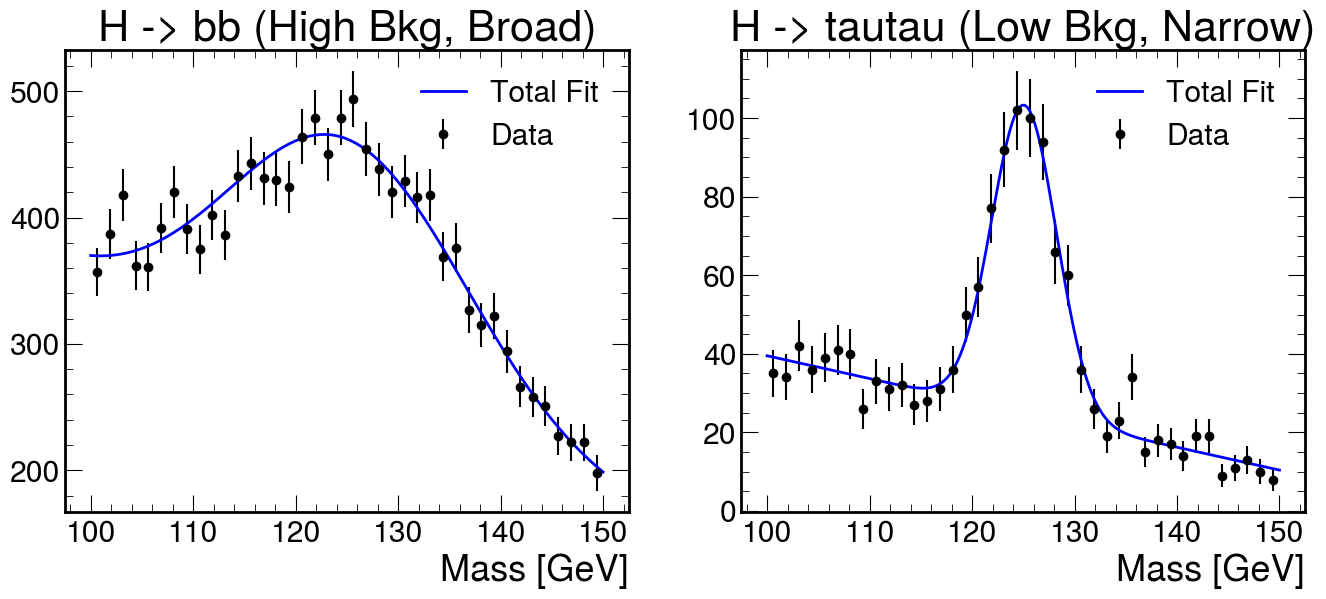

In [24]:

# ==========================================
# PLOTTING
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

def simple_plot(ax, model, data, title):
    data_np = data.value("mass").numpy().flatten()
    Y, X = np.histogram(data_np, bins=40, range=(100, 150))
    x_plot = np.linspace(100, 150, 200)

    # Scale model
    model_pdf = model.pdf(x_plot.reshape(-1,1)).numpy()
    total_yield = model.get_yield().numpy()
    bin_width = (150-100)/40
    y_plot = model_pdf * total_yield * bin_width

    centers = (X[1:]+X[:-1])/2
    ax.errorbar(centers, Y, yerr=np.sqrt(Y), fmt='ko', label="Data")
    ax.plot(x_plot, y_plot, 'b-', linewidth=2, label="Total Fit")

    ax.set_title(title)
    ax.set_xlabel("Mass [GeV]")
    ax.legend()

simple_plot(ax1, model_bb, data_bb, "H -> bb (High Bkg, Broad)")
simple_plot(ax2, model_tautau, data_tautau, "H -> tautau (Low Bkg, Narrow)")
plt.show()

## 2D Fits

So far, we have only looked at 1D distributions (e.g., Mass). But in particle physics, we often measure multiple independent properties for each event. For example:
* **$D_s$ Mass** vs **$\eta$ Mass** (to separate signal from specific backgrounds).
* **Mass** vs **Decay Time** (to measure lifetimes).
* **Mass** vs **Momentum** (to check for kinematic reflections).

Fitting multiple dimensions simultaneously allows us to separate backgrounds that might look identical to the signal in one projection but distinct in another.

### The Mathematics of 2D Fits
To perform a 2D fit, we need a model that depends on two variables: $PDF(x, y)$.

#### Case A: Uncorrelated Variables (The "Product PDF")
If the two variables $x$ and $y$ are **independent** (knowing $x$ tells you nothing about $y$), the total probability is simply the product of the individual probabilities:

$$PDF(x, y) = PDF_x(x) \cdot PDF_y(y)$$

In `zfit`, we build this using `zfit.pdf.ProductPDF([pdf_x, pdf_y])`.





#### Case B: Correlated Variables (The Danger Zone)
If $x$ and $y$ are **correlated** (e.g., higher mass events tend to have higher momentum), the product approach **fails**.

$$PDF(x, y) \neq PDF_x(x) \cdot PDF_y(y)$$

In correlated cases, you cannot simply multiply two 1D shapes. You must use:
1.  **Conditional PDFs:** $P(x, y) = P(x) \cdot P(y|x)$ (e.g., the width of $y$ depends on $x$).
2.  **Multi-dimensional functions:** Like a 2D Gaussian with a covariance term.

**Warning:** Always check correlation coefficients (`df.corr()`) before assuming you can use a `ProductPDF`. If you fit correlated data with a product model, your results (yields and errors) will be biased!

**Example:** Uncorrelated 2D fit to mass and lifetime

In [44]:
# 1. Define Spaces
mass = zfit.Space("mass", limits=(5100, 5600))
time = zfit.Space("time", limits=(0, 2))

# 2. Parameters
tau_sig = zfit.Parameter("tau_sig", 1.5, 0.1, 3.0)
tau_bkg = zfit.Parameter("tau_bkg", 0.4, 0.01, 1.0)

# 3. PDFs
mu2 = zfit.Parameter("mu2", 5379, 5300, 5450)
# Mass
sig_m = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=mass)
bkg_m = zfit.pdf.Gauss(mu=mu2, sigma=sigma, obs=mass)

# Time
sig_t = zfit.pdf.Exponential(lambda_=-1/tau_sig, obs=time)
bkg_t = zfit.pdf.Exponential(lambda_=-1/tau_bkg, obs=time)

# 4. Product PDFs (2D)
sig_2d = zfit.pdf.ProductPDF([sig_m, sig_t])
bkg_2d = zfit.pdf.ProductPDF([bkg_m, bkg_t])

# 5. Total Model
model_2d = zfit.pdf.SumPDF([sig_2d, bkg_2d], fracs=0.5)

# 6. Generate 2D Data
data_2d = model_2d.sample(10000)

# 7. Fit
nll_2d = zfit.loss.UnbinnedNLL(model_2d, data_2d)
result_2d = minimizer.minimize(nll_2d)
print(result_2d.params)

name      value  (rounded)    at limit
------  ------------------  ----------
mu                 5280.91       False
sigma              26.1002       False
mu2                5378.72       False


/tmp/ipython-input-1282439006.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xlim = (float(lx[0]), float(ux[0]))
/tmp/ipython-input-1282439006.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ylim = (float(ly[0]), float(uy[0]))


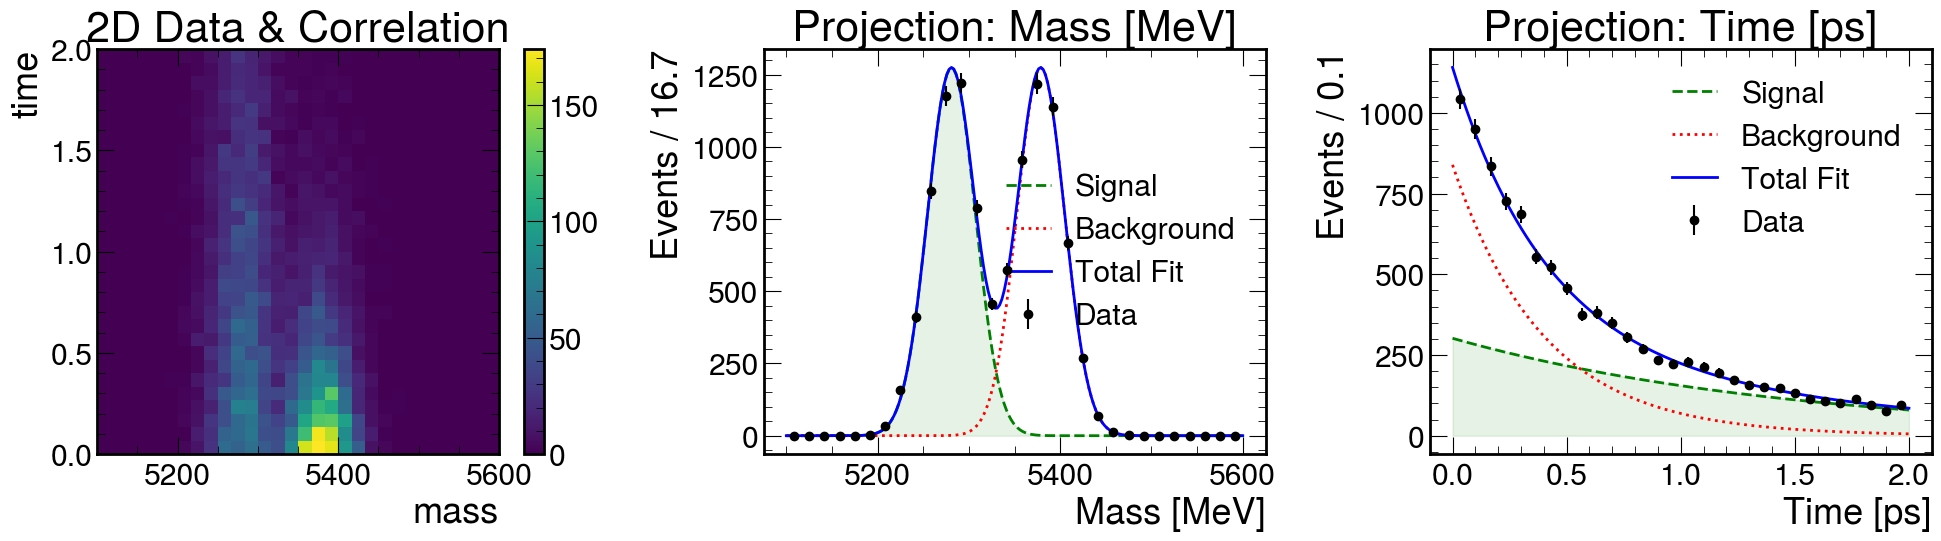

In [45]:
def plot_2d_fit_v2(model, data, obs_x, obs_y, bins=30):
    """
    Robust 2D Plotting for zfit 0.28.0
    Uses independent 1D spaces for limits to avoid shape errors.
    """
    # ==========================================
    # 1. SETUP & SAFETY
    # ==========================================
    # Get string names
    name_x = obs_x.obs[0]
    name_y = obs_y.obs[0]

    # SAFE LIMIT EXTRACTION (Crucial Step)
    # We ask the 1D space (obs_x) for its limits, not the 2D model
    # rect_limits returns (lower_arr, upper_arr)
    lx, ux = obs_x.rect_limits
    ly, uy = obs_y.rect_limits

    # Convert single-element arrays to pure Python floats
    xlim = (float(lx[0]), float(ux[0]))
    ylim = (float(ly[0]), float(uy[0]))

    # Extract Data (Order is guaranteed by passing list of names)
    data_np = data.value([name_x, name_y]).numpy()
    x_data = data_np[:, 0]
    y_data = data_np[:, 1]

    # ==========================================
    # 2. PLOTTING
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # --- PLOT 1: 2D Heatmap ---
    h = axes[0].hist2d(x_data, y_data, bins=bins, range=[xlim, ylim], cmap='viridis')
    axes[0].set_xlabel(name_x)
    axes[0].set_ylabel(name_y)
    axes[0].set_title("2D Data & Correlation")
    fig.colorbar(h[3], ax=axes[0])

    # --- Helper: Plot 1D Projections ---
    def plot_proj(ax, data_1d, obs_name, limits, title):
        # 1. Plot Data
        counts, edges = np.histogram(data_1d, bins=bins, range=limits)
        centers = (edges[:-1] + edges[1:]) / 2
        yerr = np.sqrt(counts)
        ax.errorbar(centers, counts, yerr=yerr, fmt='ko', label="Data", zorder=10)

        # 2. Setup Evaluation Grid
        x_plot = np.linspace(limits[0], limits[1], 200)
        bin_width = (limits[1] - limits[0]) / bins
        scale = len(data_1d) * bin_width

        # 3. Model Evaluation (Factorization Strategy)
        # We reconstruct the total PDF by summing the relevant 1D factors
        y_total = np.zeros_like(x_plot)

        # Get Model Fractions
        # Handle cases where fracs are not explicitly full length
        fracs = [f.numpy() for f in model.fracs]
        if len(fracs) < len(model.pdfs):
            fracs.append(1.0 - sum(fracs))

        styles = ['g--', 'r:', 'm-.']

        # Iterate over 2D components (Signal 2D, Background 2D)
        for i, (pdf_2d, frac) in enumerate(zip(model.pdfs, fracs)):

            # Find the 1D factor inside this 2D product that matches our axis
            pdf_1d = None
            for factor in pdf_2d.pdfs:
                if factor.obs[0] == obs_name:
                    pdf_1d = factor
                    break

            if pdf_1d:
                # Calculate Component Shape
                y_comp = pdf_1d.pdf(x_plot.reshape(-1, 1)).numpy() * scale * frac
                y_total += y_comp

                # Plot Component
                label = "Signal" if i == 0 else "Background"
                ax.plot(x_plot, y_comp, styles[i % len(styles)], linewidth=2, label=label)
                if i == 0: ax.fill_between(x_plot, y_comp, color='g', alpha=0.1)

        # Plot Total Sum
        ax.plot(x_plot, y_total, 'b-', linewidth=2, label="Total Fit")

        ax.set_xlabel(title)
        ax.set_ylabel(f"Events / {bin_width:.1f}")
        ax.set_title(f"Projection: {title}")
        ax.legend()

    # --- PLOT 2 & 3: Run Projections ---
    plot_proj(axes[1], x_data, name_x, xlim, "Mass [MeV]")
    plot_proj(axes[2], y_data, name_y, ylim, "Time [ps]")

    plt.tight_layout()
    plt.show()

# Run it
plot_2d_fit_v2(model_2d, data_2d, mass, time)

**Exercise:** You are analyzing data from a high-energy physics experiment (like LHCb). You are studying the rare decay of charmed mesons into an $\eta$ meson and a pion:

1. $D_s^+ \to \eta \pi^+$
2. $D^+ \to \eta \pi^+$

In both cases, the  meson is reconstructed via its dimuon decay mode: : $\eta \to \mu^+ \mu^-$.
Your physics objective is to measure the branching ratio $\mathcal{B}(\eta \to \mu^+\mu^-)$.
This branching ratio is a fundamental constant of nature and must be the **same** regardless of whether the $\eta$ meson came from a  $D_s^+$ or a $D^+$.

You have two [datasets](https://www.dropbox.com/scl/fi/xd5tn9444ggn307d7qzih/zfit_ex_datasets.zip?rlkey=vvfldbo1hjgaiapfhvtupolxr&dl=1): `dataset_Ds.csv` and `dataset_Dp.csv`.


* **Sample A ($D^+_s$):** Events selected near the $D_s^+$ mass.
* **Sample B ($D^+$):** Events selected near the $D^+$ mass.

Instead of fitting $N_{sig}$ independently and calculating the Branching Ratio (BR) offline, you will perform a Simultaneous Fit to both samples. You will parameterize the signal yield $N_{sig}$ in the fit directly as a function of the physics parameter $\mathcal{B}(\eta \to \mu\mu)$ and a normalization factor $\alpha$ (which includes luminosity, cross-section, and efficiency).

$$\mathcal{B}(\eta \to \mu\mu) = N_{sig} \cdot \alpha \quad \Rightarrow \quad N_{sig}(\mathcal{B}) = \frac{\mathcal{B}}{\alpha}$$

You are given the sensitivity factors $\alpha$ for each channel:

$\alpha_{D^+_s} = 2.5 \times 10^{-5}$

$\alpha_{D^+} = 8.0 \times 10^{-5}$


You are dealing with a 2D problem. The observables are:

1. `mass_D`: The invariant mass of the  $\mu\mu\pi$ system.
2. `mass_eta`: The invariant mass of the  $\mu\mu$ system.

This sample contains three components:

###### Sample 1:  $D_s^+$ Region

This sample contains three components:

1. **Signal ($D^+_s \to \eta \pi$):**
* `mass_D`: Gaussian (Peak at $m_{D^+_s}$).
* `mass_eta`: Gaussian (Peak at $m_\eta$).


2. **Combinatorial Background:**
* `mass_D`: Exponential.
* `mass_eta`: Exponential.


3. **Real $\eta$ Background (Fake $D^+_s$)**:
Contains a real $\eta$, but combined with a random pion:
* `mass_D`: Exponential  (No $D^+_s$ peak).
* `mass_eta`: Gaussian (Real $\eta$ peak).


###### Sample 2:  $D^+$ Region

This sample contains three components:

1. **Signal ($D^+ \to \eta \pi$):**
* `mass_D`: Gaussian (Peak at $m_{D^+}$).
* `mass_eta`: Gaussian (Peak at $m_\eta$).


2. **Combinatorial Background:**
* `mass_D`: Exponential.
* `mass_eta`: Exponential.

3. **Non-Resonant Background (Real $D^+$):**
Contains a real $D^+ \to \mu\mu\pi$ decay, but the muons are not from an $\eta$ meson.
* `mass_D`: Gaussian (Real $D^+$ peak).
* `mass_eta`: Exponential (No $\eta$ peak).


###### Tasks

1. **Model Building:** Construct the 2D PDFs for all 6 components (3 for , 3 for ) using `zfit`. Try to discuss the *meaning* or *origin* of each of the components mentioned above. *Hint:* The Signal and the "Real" background must share the same  mass shape parameters. The centers of the gaussians should be roughly the masses of the relevant particles. You can assume their widths to the be in the range of 5-20 MeV. The background slopes are small and negative, in the $(-10^{-2},-10^{-3})$ range.

2. **Parameterization:** Create a shared parameter `BR_eta_mumu`. Define the signal yields for both samples as composed parameters dependent on this BR.
3. **Simultaneous Fit:** Perform a simultaneous fit to both datasets.
4. **Validation:** Plot the projections of the fit (Mass  and Mass ) for both samples.
5. **Result:** Result: Report the fitted value of $\mathcal{B}(\eta \to \mu\mu)$ and its uncertainty. Does it cover the true value?
6. **Discuss:** How does the precision you achieve in the BR compare to the current world best? How would you improve it? Is there any effect going into the BR uncertainty you are missing?